# 离群点分析与异常值检测

## 数据集：wave_benchmark

### 1.导库

In [2]:
import pandas as pd
from sklearn import metrics
from scipy import interpolate
import numpy as np
import os
import csv
import collections
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.abod import ABOD
from pyod.models.pca import PCA
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.abod import ABOD
from pyod.models.loda import LODA
from pyod.models.lscp import LSCP
from sklearn.datasets import make_classification
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import precision_n_scores
import time
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.style.use('ggplot')

### 2.加载数据集

In [3]:
data = pd.read_csv('./wave_benchmarks/wave/meta_data/meta_wave.csv')

In [4]:
data.head()

,bench.id,benchnum,origin,mset,size,n.anom,n.norm,anomaly.rate.level,point.difficulty.level,clustering.algo,irrelevance.level,anomaly.rate,diff.mean,anom.diff.mean,norm.diff.mean,clusteredness.score,irrelevance.score,auc.ci.0.999,ap.ci.0.999
0,wave_benchmark_0001,1,multiclass,wave,3010,992,2018,ar-0,pd-0,none,ir-0,0.329568,0.096062,0.163355,0.062982,0.092438,0.0,0.528388,0.360212
1,wave_benchmark_0002,2,multiclass,wave,3010,1037,1973,ar-0,pd-0,none,ir-0,0.344518,0.094091,0.149707,0.064860,0.118728,0.0,0.527560,0.375413
2,wave_benchmark_0003,3,multiclass,wave,3010,1012,1998,ar-0,pd-0,none,ir-0,0.336213,0.092652,0.153313,0.061927,0.115778,0.0,0.528051,0.366852
3,wave_benchmark_0004,4,multiclass,wave,3010,966,2044,ar-0,pd-0,none,ir-0,0.320930,0.092315,0.150804,0.064672,0.124502,0.0,0.528571,0.351629
4,wave_benchmark_0005,5,multiclass,wave,3010,1030,1980,ar-0,pd-0,none,ir-0,0.342193,0.093889,0.153379,0.062942,0.124691,0.0,0.527824,0.373069


In [5]:
ar = data['anomaly.rate']
ar_level = data['anomaly.rate.level']

In [6]:
#查看异常值等级
set(ar_level)

{'ar-0', 'ar-1', 'ar-2', 'ar-3', 'ar-4', 'ar-6'}

#### 数据集中，共有6个异常点比例等级

#### 输出各等级异常数据的比例和均值

In [7]:
data_dic = collections.defaultdict(list)
for item in data.iterrows():
    data_dic[item[1]['anomaly.rate.level']].append(item[1]['bench.id'])

In [8]:
data[['anomaly.rate','anomaly.rate.level']].groupby(['anomaly.rate.level']).count()

,anomaly.rate
anomaly.rate.level,
ar-0,300
ar-1,180
ar-2,180
ar-3,160
ar-4,130
ar-6,130


In [10]:
data_g = data[['anomaly.rate','anomaly.rate.level']].groupby(['anomaly.rate.level']).mean()
data_g

,anomaly.rate
anomaly.rate.level,
ar-0,0.411288
ar-1,0.001499
ar-2,0.005359
ar-3,0.010337
ar-4,0.050225
ar-6,0.100216


In [11]:
ar_mean = data_g['anomaly.rate'].tolist()

### 数据集中的特征

In [13]:
data = pd.read_csv('./wave_benchmarks/wave/benchmarks/wave_benchmark_0001.csv')

In [14]:
data.head(5)

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,...,V.11,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20
0,wave_point_0242,wave,multiclass,2,0.001130,nominal,0.440395,-0.293023,-1.374141,-2.382361,...,0.235635,0.581920,0.745048,0.674833,0.397361,0.008963,1.677061,0.800549,-0.441398,-1.583270
1,wave_point_4490,wave,multiclass,0,0.474350,anomaly,0.093905,-0.093717,1.891936,1.002227,...,-0.134625,-1.791554,-0.698042,-0.598220,-0.894968,-0.823398,0.799381,-0.744561,0.418648,-1.613359
2,wave_point_0454,wave,multiclass,2,0.000153,nominal,1.123475,-0.558765,0.688201,-1.336601,...,1.538160,1.629397,1.017757,-0.241567,-0.094166,0.272444,-1.012604,-1.337549,-0.885293,-0.219266
3,wave_point_2033,wave,multiclass,0,0.354121,anomaly,1.301670,-1.479368,-1.087939,-1.025700,...,-0.167684,1.193453,1.012076,2.022189,3.236067,2.170706,0.990489,2.095101,2.767593,1.435593
4,wave_point_2294,wave,multiclass,0,0.349918,anomaly,-0.896067,-0.055754,-0.380850,1.221271,...,-1.536327,-1.500924,-0.976433,-0.261381,-0.342690,-1.571924,-0.403890,-0.569170,-1.181223,-0.640502


### 选择特征，21个特征

In [15]:
data.columns[6:]

Index(['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9',
       'V.10', 'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16', 'V.17', 'V.18',
       'V.19', 'V.20'],
      dtype='object')

### 定义评估函数

In [16]:
def evaluation(y, y_scores, method):
    '''
    评估函数，y为groundtruth，y_scores为预测值，返回PR曲线，ROC曲线和AUC
    '''
    if isinstance(y_scores, dict):
        colors = ['r', 'g', 'b', '#FF1493', '#483D8B']
        plt.figure(figsize=(7,7))
        i = 0
        for algo in y_scores:
            pre_scr = y_scores[algo]
            print(algo, pre_scr.shape)
            fpr_level = np.arange(0, 1, 0.01)
            fpr, tpr, threshold = metrics.roc_curve(y, pre_scr)
            interp = interpolate.interp1d(fpr, tpr)
            tpr_at_fpr = [interp(x) for x in fpr_level]
            roc_auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, color=colors[i], label='%s ROC(area = %0.2f)' % (algo, roc_auc))
            i += 1
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('Models Compare' + '-ROC')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.legend(loc="lower right")
    else:
        fpr_level = np.arange(0, 1, 0.01)
        fpr, tpr, threshold = metrics.roc_curve(y, y_scores)
        interp = interpolate.interp1d(fpr, tpr)
        tpr_at_fpr = [interp(x) for x in fpr_level]
        roc_auc = metrics.auc(fpr, tpr)
        precision, recall, _ = metrics.precision_recall_curve(y, y_scores)
        pr_auc = round(precision_n_scores(y, y_scores), ndigits=4)
#         pr_auc_t = metrics.auc(recall, precision)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(method + '-ROC')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.legend(loc="lower right")
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, marker='.', label='precision @ rank n: %0.2f)' % pr_auc)
        plt.legend(loc="upper right")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(method + '-PR')
        plt.show()

### 对原始数据集进行抽样，每一个异常点level选择一个benchmark，共6个benchmark进行拼接，并读取groundturth和特征属性

In [17]:
path = './wave_benchmarks/wave/benchmarks'
samples = []
for item in data_dic:
    samples.append(data_dic[item][0])
y = []
x_train = []
contam = 0
for sample in samples:
    p = os.path.join(path, sample+'.csv')
    data = pd.read_csv(p)
    data = data.dropna()
    for i in data.iterrows():
        # 0为正常，1为异常点
        if i[1][5] == 'anomaly':
            y.append(1)
            contam += 1
        else:
            y.append(0)
        x_train.append(list(i[1][6:17]))
x_train = np.array(x_train)
y = np.array(y)
contam /= len(y)

In [18]:
samples

['wave_benchmark_0001',
 'wave_benchmark_0301',
 'wave_benchmark_0601',
 'wave_benchmark_0901',
 'wave_benchmark_1201',
 'wave_benchmark_1501']

In [19]:
contam

0.08265662812584028

### 3.离群点检测

基于近邻(KNN，LOF)

Linear Model(PCA)

Outlier Ensembles(LODA)


In [20]:
algorithms = ['KNN', 'LOF', 'PCA', 'LODA']
all_scores = {}

### 比较不同算法

### 1.KNN

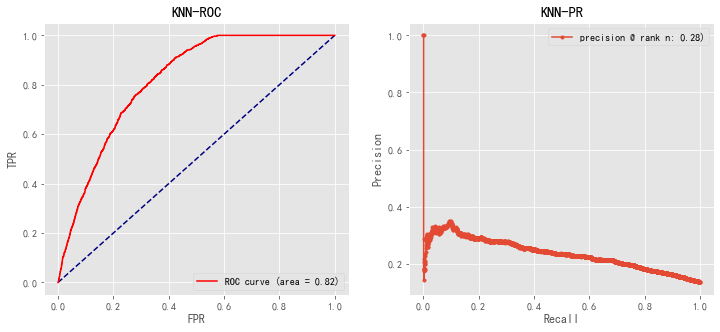

In [21]:
clf_name = 'KNN'
clf = KNN(n_neighbors=5, contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
knn_y_pred = clf.labels_  
knn_y_scores = clf.decision_scores_  
evaluation(y, knn_y_scores, clf_name)
all_scores['KNN'] = knn_y_scores

### 2.LOF

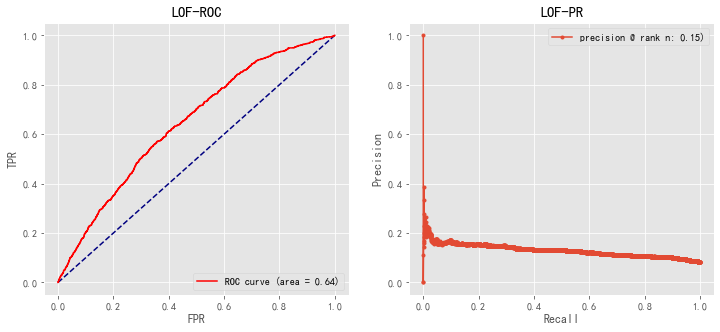

In [22]:
clf_name = 'LOF'
clf = LOF(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  
y_scores = clf.decision_scores_  
evaluation(y, y_scores, clf_name)
all_scores['LOF'] = y_scores 

### 3.PCA

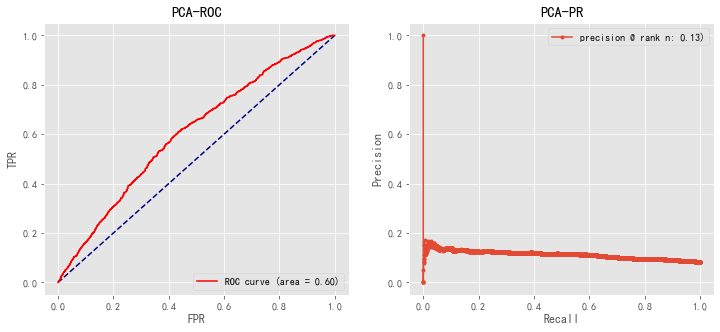

In [23]:
clf_name = 'PCA'
clf = PCA(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  
y_scores = clf.decision_scores_  
evaluation(y, y_scores, clf_name)
all_scores['PCA'] = y_scores 

### 4.LODA

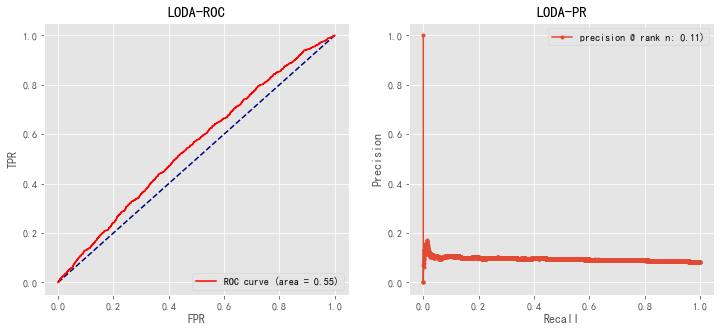

In [24]:
clf_name = 'LODA'
clf = LODA(contamination=contam)
x_train = standardizer(x_train)
clf.fit(x_train)
y_pred = clf.labels_  
y_scores = clf.decision_scores_  
evaluation(y, y_scores, clf_name)
all_scores['LODA'] = y_scores 

KNN (18595,)
LOF (18595,)
PCA (18595,)
LODA (18595,)


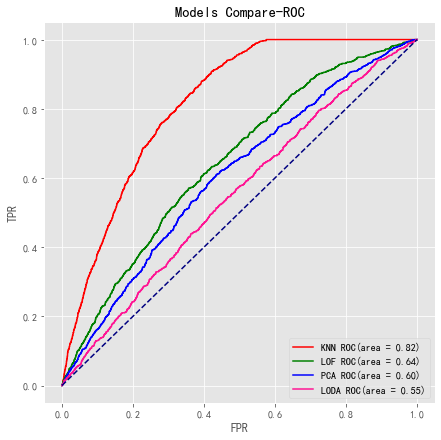

In [25]:
evaluation(y, all_scores, algorithms)

### 在同一个benchmark下，KNN表现最好，ROC-AUC为0.82，PCA表现最差，仅有0.55

### 在所有样本上进行模型，输出auc到表格

In [26]:
results = collections.defaultdict(list)
with open('results_wave.csv', 'w', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['benchmark_id', 'Model', 'ROC', 'precision at rank n', 'execution time'])
    for item in data_dic:
        for bench_id in data_dic[item]:
            x_item = []
            y_item = []
            contam = 0
            p = os.path.join(path, bench_id+'.csv')
            for i in pd.read_csv(p).iterrows():
                if i[1][5] == 'anomaly':
                    y_item.append(1)
                    contam += 1
                else:
                    y_item.append(0)
                x_item.append(list(i[1][6:17]))
            x_item = np.array(x_item)
            y_item = np.array(y_item)
            contam /= len(y_item)
            contam = min(0.5, contam)
            # 定义模型
            classifiers = {'KNN': KNN(contamination=contam),
                           'LOF': LOF(contamination=contam),
                           'PCA': PCA(contamination=contam),
                           'LODA': LODA(contamination=contam)
                          }
            for cls in classifiers:
                clf = classifiers[cls]
                t0 = time.time()
                x_item = standardizer(x_item)
                clf.fit(x_item)
                y_scores = clf.decision_function(x_item)
                t1 = time.time()
                duration = round(t1 - t0, ndigits=4)

                roc = round(roc_auc_score(y_item, y_scores), ndigits=4)
                prn = round(precision_n_scores(y_item, y_scores), ndigits=4)
                results[cls].append(roc)
                
                print('benchmark id:{bench_id}, model:{clf_name}, ROC:{roc}, precision @ rank n:{prn}, '
                      'execution time: {duration}s'.format(
                    bench_id=bench_id, clf_name=cls, roc=roc, prn=prn, duration=duration))

                csv_writer.writerow([bench_id, cls, roc, prn, duration])

f.close()

benchmark id:wave_benchmark_0001, model:KNN, ROC:0.5152, precision @ rank n:0.3458, execution time: 0.5005s
benchmark id:wave_benchmark_0001, model:LOF, ROC:0.5097, precision @ rank n:0.3347, execution time: 0.4727s
benchmark id:wave_benchmark_0001, model:PCA, ROC:0.4919, precision @ rank n:0.3417, execution time: 0.005s
benchmark id:wave_benchmark_0001, model:LODA, ROC:0.499, precision @ rank n:0.3397, execution time: 0.0645s
benchmark id:wave_benchmark_0002, model:KNN, ROC:0.4887, precision @ rank n:0.3394, execution time: 0.5461s
benchmark id:wave_benchmark_0002, model:LOF, ROC:0.4915, precision @ rank n:0.3423, execution time: 0.4528s
benchmark id:wave_benchmark_0002, model:PCA, ROC:0.4681, precision @ rank n:0.3375, execution time: 0.0055s
benchmark id:wave_benchmark_0002, model:LODA, ROC:0.5134, precision @ rank n:0.3626, execution time: 0.0526s
benchmark id:wave_benchmark_0003, model:KNN, ROC:0.5118, precision @ rank n:0.3389, execution time: 0.4801s
benchmark id:wave_benchmark_

benchmark id:wave_benchmark_0020, model:KNN, ROC:0.5168, precision @ rank n:0.3429, execution time: 0.5337s
benchmark id:wave_benchmark_0020, model:LOF, ROC:0.496, precision @ rank n:0.3241, execution time: 0.4538s
benchmark id:wave_benchmark_0020, model:PCA, ROC:0.4875, precision @ rank n:0.332, execution time: 0.0064s
benchmark id:wave_benchmark_0020, model:LODA, ROC:0.4074, precision @ rank n:0.2724, execution time: 0.0645s
benchmark id:wave_benchmark_0021, model:KNN, ROC:0.5379, precision @ rank n:0.3576, execution time: 0.5243s
benchmark id:wave_benchmark_0021, model:LOF, ROC:0.5277, precision @ rank n:0.3625, execution time: 0.4603s
benchmark id:wave_benchmark_0021, model:PCA, ROC:0.5459, precision @ rank n:0.3884, execution time: 0.0055s
benchmark id:wave_benchmark_0021, model:LODA, ROC:0.6255, precision @ rank n:0.4502, execution time: 0.0655s
benchmark id:wave_benchmark_0022, model:KNN, ROC:0.5332, precision @ rank n:0.3663, execution time: 0.5258s
benchmark id:wave_benchmark_

benchmark id:wave_benchmark_0039, model:KNN, ROC:0.5583, precision @ rank n:0.3751, execution time: 0.5308s
benchmark id:wave_benchmark_0039, model:LOF, ROC:0.5306, precision @ rank n:0.343, execution time: 0.4732s
benchmark id:wave_benchmark_0039, model:PCA, ROC:0.5574, precision @ rank n:0.4, execution time: 0.0069s
benchmark id:wave_benchmark_0039, model:LODA, ROC:0.5412, precision @ rank n:0.372, execution time: 0.0655s
benchmark id:wave_benchmark_0040, model:KNN, ROC:0.5323, precision @ rank n:0.347, execution time: 0.5183s
benchmark id:wave_benchmark_0040, model:LOF, ROC:0.5036, precision @ rank n:0.3183, execution time: 0.4583s
benchmark id:wave_benchmark_0040, model:PCA, ROC:0.5526, precision @ rank n:0.3891, execution time: 0.006s
benchmark id:wave_benchmark_0040, model:LODA, ROC:0.554, precision @ rank n:0.3799, execution time: 0.0635s
benchmark id:wave_benchmark_0041, model:KNN, ROC:0.5102, precision @ rank n:0.3303, execution time: 0.6379s
benchmark id:wave_benchmark_0041, 

benchmark id:wave_benchmark_0058, model:LOF, ROC:0.5015, precision @ rank n:0.3233, execution time: 0.4628s
benchmark id:wave_benchmark_0058, model:PCA, ROC:0.4831, precision @ rank n:0.3182, execution time: 0.0064s
benchmark id:wave_benchmark_0058, model:LODA, ROC:0.4965, precision @ rank n:0.3244, execution time: 0.068s
benchmark id:wave_benchmark_0059, model:KNN, ROC:0.4906, precision @ rank n:0.3303, execution time: 0.5163s
benchmark id:wave_benchmark_0059, model:LOF, ROC:0.4969, precision @ rank n:0.3254, execution time: 0.4652s
benchmark id:wave_benchmark_0059, model:PCA, ROC:0.4775, precision @ rank n:0.3244, execution time: 0.0059s
benchmark id:wave_benchmark_0059, model:LODA, ROC:0.491, precision @ rank n:0.3333, execution time: 0.0694s
benchmark id:wave_benchmark_0060, model:KNN, ROC:0.5123, precision @ rank n:0.3343, execution time: 0.5377s
benchmark id:wave_benchmark_0060, model:LOF, ROC:0.4997, precision @ rank n:0.3333, execution time: 0.5079s
benchmark id:wave_benchmark_

benchmark id:wave_benchmark_0077, model:LOF, ROC:0.5156, precision @ rank n:0.3493, execution time: 0.4568s
benchmark id:wave_benchmark_0077, model:PCA, ROC:0.4757, precision @ rank n:0.3333, execution time: 0.0064s
benchmark id:wave_benchmark_0077, model:LODA, ROC:0.481, precision @ rank n:0.3164, execution time: 0.0645s
benchmark id:wave_benchmark_0078, model:KNN, ROC:0.4816, precision @ rank n:0.3207, execution time: 0.56s
benchmark id:wave_benchmark_0078, model:LOF, ROC:0.4926, precision @ rank n:0.3257, execution time: 0.488s
benchmark id:wave_benchmark_0078, model:PCA, ROC:0.4627, precision @ rank n:0.3157, execution time: 0.0084s
benchmark id:wave_benchmark_0078, model:LODA, ROC:0.4331, precision @ rank n:0.2837, execution time: 0.0799s
benchmark id:wave_benchmark_0079, model:KNN, ROC:0.4909, precision @ rank n:0.3406, execution time: 0.7554s
benchmark id:wave_benchmark_0079, model:LOF, ROC:0.5168, precision @ rank n:0.354, execution time: 0.4766s
benchmark id:wave_benchmark_007

benchmark id:wave_benchmark_0097, model:KNN, ROC:0.5469, precision @ rank n:0.3673, execution time: 0.5322s
benchmark id:wave_benchmark_0097, model:LOF, ROC:0.5105, precision @ rank n:0.3382, execution time: 0.4736s
benchmark id:wave_benchmark_0097, model:PCA, ROC:0.5487, precision @ rank n:0.3984, execution time: 0.006s
benchmark id:wave_benchmark_0097, model:LODA, ROC:0.5553, precision @ rank n:0.3994, execution time: 0.0635s
benchmark id:wave_benchmark_0098, model:KNN, ROC:0.5472, precision @ rank n:0.3735, execution time: 0.6617s
benchmark id:wave_benchmark_0098, model:LOF, ROC:0.5292, precision @ rank n:0.3625, execution time: 0.4925s
benchmark id:wave_benchmark_0098, model:PCA, ROC:0.5462, precision @ rank n:0.3944, execution time: 0.0069s
benchmark id:wave_benchmark_0098, model:LODA, ROC:0.498, precision @ rank n:0.3466, execution time: 0.066s
benchmark id:wave_benchmark_0099, model:KNN, ROC:0.5538, precision @ rank n:0.3702, execution time: 0.5277s
benchmark id:wave_benchmark_0

benchmark id:wave_benchmark_0116, model:KNN, ROC:0.5042, precision @ rank n:0.3289, execution time: 0.5243s
benchmark id:wave_benchmark_0116, model:LOF, ROC:0.5037, precision @ rank n:0.3309, execution time: 0.5238s
benchmark id:wave_benchmark_0116, model:PCA, ROC:0.4873, precision @ rank n:0.3247, execution time: 0.006s
benchmark id:wave_benchmark_0116, model:LODA, ROC:0.5795, precision @ rank n:0.3806, execution time: 0.0823s
benchmark id:wave_benchmark_0117, model:KNN, ROC:0.5132, precision @ rank n:0.3367, execution time: 0.5283s
benchmark id:wave_benchmark_0117, model:LOF, ROC:0.5022, precision @ rank n:0.3256, execution time: 0.4732s
benchmark id:wave_benchmark_0117, model:PCA, ROC:0.4825, precision @ rank n:0.3327, execution time: 0.0055s
benchmark id:wave_benchmark_0117, model:LODA, ROC:0.4395, precision @ rank n:0.2905, execution time: 0.067s
benchmark id:wave_benchmark_0118, model:KNN, ROC:0.4948, precision @ rank n:0.3172, execution time: 0.5739s
benchmark id:wave_benchmark_

benchmark id:wave_benchmark_0135, model:LOF, ROC:0.5103, precision @ rank n:0.3853, execution time: 0.3591s
benchmark id:wave_benchmark_0135, model:PCA, ROC:0.4249, precision @ rank n:0.331, execution time: 0.0045s
benchmark id:wave_benchmark_0135, model:LODA, ROC:0.3851, precision @ rank n:0.3028, execution time: 0.059s
benchmark id:wave_benchmark_0136, model:KNN, ROC:0.4637, precision @ rank n:0.3391, execution time: 0.4196s
benchmark id:wave_benchmark_0136, model:LOF, ROC:0.5093, precision @ rank n:0.377, execution time: 0.3417s
benchmark id:wave_benchmark_0136, model:PCA, ROC:0.4299, precision @ rank n:0.3381, execution time: 0.005s
benchmark id:wave_benchmark_0136, model:LODA, ROC:0.44, precision @ rank n:0.3299, execution time: 0.0565s
benchmark id:wave_benchmark_0137, model:KNN, ROC:0.468, precision @ rank n:0.3553, execution time: 0.4192s
benchmark id:wave_benchmark_0137, model:LOF, ROC:0.4994, precision @ rank n:0.3839, execution time: 0.3497s
benchmark id:wave_benchmark_0137,

benchmark id:wave_benchmark_0155, model:KNN, ROC:0.492, precision @ rank n:0.3583, execution time: 0.4771s
benchmark id:wave_benchmark_0155, model:LOF, ROC:0.5417, precision @ rank n:0.3807, execution time: 0.4385s
benchmark id:wave_benchmark_0155, model:PCA, ROC:0.4867, precision @ rank n:0.3617, execution time: 0.0065s
benchmark id:wave_benchmark_0155, model:LODA, ROC:0.4574, precision @ rank n:0.3303, execution time: 0.0649s
benchmark id:wave_benchmark_0156, model:KNN, ROC:0.4953, precision @ rank n:0.3533, execution time: 0.4245s
benchmark id:wave_benchmark_0156, model:LOF, ROC:0.5351, precision @ rank n:0.3743, execution time: 0.3408s
benchmark id:wave_benchmark_0156, model:PCA, ROC:0.4997, precision @ rank n:0.361, execution time: 0.005s
benchmark id:wave_benchmark_0156, model:LODA, ROC:0.5004, precision @ rank n:0.3621, execution time: 0.0605s
benchmark id:wave_benchmark_0157, model:KNN, ROC:0.4854, precision @ rank n:0.3367, execution time: 0.3938s
benchmark id:wave_benchmark_0

benchmark id:wave_benchmark_0174, model:LOF, ROC:0.5059, precision @ rank n:0.377, execution time: 0.3551s
benchmark id:wave_benchmark_0174, model:PCA, ROC:0.4199, precision @ rank n:0.334, execution time: 0.0055s
benchmark id:wave_benchmark_0174, model:LODA, ROC:0.4165, precision @ rank n:0.324, execution time: 0.063s
benchmark id:wave_benchmark_0175, model:KNN, ROC:0.4636, precision @ rank n:0.3463, execution time: 0.4276s
benchmark id:wave_benchmark_0175, model:LOF, ROC:0.5059, precision @ rank n:0.3814, execution time: 0.3754s
benchmark id:wave_benchmark_0175, model:PCA, ROC:0.4254, precision @ rank n:0.3433, execution time: 0.0055s
benchmark id:wave_benchmark_0175, model:LODA, ROC:0.4209, precision @ rank n:0.3223, execution time: 0.0645s
benchmark id:wave_benchmark_0176, model:KNN, ROC:0.4668, precision @ rank n:0.3513, execution time: 0.439s
benchmark id:wave_benchmark_0176, model:LOF, ROC:0.5169, precision @ rank n:0.3878, execution time: 0.3467s
benchmark id:wave_benchmark_017

benchmark id:wave_benchmark_0194, model:KNN, ROC:0.5032, precision @ rank n:0.4806, execution time: 0.1086s
benchmark id:wave_benchmark_0194, model:LOF, ROC:0.5047, precision @ rank n:0.4761, execution time: 0.0516s
benchmark id:wave_benchmark_0194, model:PCA, ROC:0.4834, precision @ rank n:0.4579, execution time: 0.0039s
benchmark id:wave_benchmark_0194, model:LODA, ROC:0.488, precision @ rank n:0.4556, execution time: 0.0436s
benchmark id:wave_benchmark_0195, model:KNN, ROC:0.4885, precision @ rank n:0.4693, execution time: 0.1131s
benchmark id:wave_benchmark_0195, model:LOF, ROC:0.4981, precision @ rank n:0.4759, execution time: 0.0526s
benchmark id:wave_benchmark_0195, model:PCA, ROC:0.4891, precision @ rank n:0.4781, execution time: 0.0039s
benchmark id:wave_benchmark_0195, model:LODA, ROC:0.4862, precision @ rank n:0.4627, execution time: 0.0441s
benchmark id:wave_benchmark_0196, model:KNN, ROC:0.4712, precision @ rank n:0.4192, execution time: 0.1076s
benchmark id:wave_benchmark

benchmark id:wave_benchmark_0213, model:KNN, ROC:0.4742, precision @ rank n:0.445, execution time: 0.1022s
benchmark id:wave_benchmark_0213, model:LOF, ROC:0.4861, precision @ rank n:0.4633, execution time: 0.0531s
benchmark id:wave_benchmark_0213, model:PCA, ROC:0.4774, precision @ rank n:0.445, execution time: 0.004s
benchmark id:wave_benchmark_0213, model:LODA, ROC:0.4851, precision @ rank n:0.4472, execution time: 0.0412s
benchmark id:wave_benchmark_0214, model:KNN, ROC:0.4745, precision @ rank n:0.4465, execution time: 0.1066s
benchmark id:wave_benchmark_0214, model:LOF, ROC:0.4802, precision @ rank n:0.4396, execution time: 0.0516s
benchmark id:wave_benchmark_0214, model:PCA, ROC:0.4871, precision @ rank n:0.4487, execution time: 0.0045s
benchmark id:wave_benchmark_0214, model:LODA, ROC:0.4807, precision @ rank n:0.4487, execution time: 0.0412s
benchmark id:wave_benchmark_0215, model:KNN, ROC:0.4713, precision @ rank n:0.4371, execution time: 0.1032s
benchmark id:wave_benchmark_0

benchmark id:wave_benchmark_0232, model:KNN, ROC:0.4772, precision @ rank n:0.4523, execution time: 0.1052s
benchmark id:wave_benchmark_0232, model:LOF, ROC:0.4776, precision @ rank n:0.4432, execution time: 0.0506s
benchmark id:wave_benchmark_0232, model:PCA, ROC:0.4823, precision @ rank n:0.4591, execution time: 0.0034s
benchmark id:wave_benchmark_0232, model:LODA, ROC:0.4684, precision @ rank n:0.4386, execution time: 0.0401s
benchmark id:wave_benchmark_0233, model:KNN, ROC:0.4825, precision @ rank n:0.4556, execution time: 0.1066s
benchmark id:wave_benchmark_0233, model:LOF, ROC:0.4888, precision @ rank n:0.4419, execution time: 0.0516s
benchmark id:wave_benchmark_0233, model:PCA, ROC:0.4761, precision @ rank n:0.4487, execution time: 0.0029s
benchmark id:wave_benchmark_0233, model:LODA, ROC:0.4793, precision @ rank n:0.451, execution time: 0.0417s
benchmark id:wave_benchmark_0234, model:KNN, ROC:0.4717, precision @ rank n:0.4595, execution time: 0.1081s
benchmark id:wave_benchmark

benchmark id:wave_benchmark_0251, model:KNN, ROC:0.5008, precision @ rank n:0.5475, execution time: 0.0461s
benchmark id:wave_benchmark_0251, model:LOF, ROC:0.5191, precision @ rank n:0.5667, execution time: 0.0139s
benchmark id:wave_benchmark_0251, model:PCA, ROC:0.5816, precision @ rank n:0.6167, execution time: 0.003s
benchmark id:wave_benchmark_0251, model:LODA, ROC:0.5639, precision @ rank n:0.5778, execution time: 0.0407s
benchmark id:wave_benchmark_0252, model:KNN, ROC:0.5108, precision @ rank n:0.573, execution time: 0.0397s
benchmark id:wave_benchmark_0252, model:LOF, ROC:0.4994, precision @ rank n:0.573, execution time: 0.0129s
benchmark id:wave_benchmark_0252, model:PCA, ROC:0.5647, precision @ rank n:0.5892, execution time: 0.0029s
benchmark id:wave_benchmark_0252, model:LODA, ROC:0.5354, precision @ rank n:0.6054, execution time: 0.0392s
benchmark id:wave_benchmark_0253, model:KNN, ROC:0.4933, precision @ rank n:0.5475, execution time: 0.0367s
benchmark id:wave_benchmark_0

benchmark id:wave_benchmark_0270, model:KNN, ROC:0.5126, precision @ rank n:0.5691, execution time: 0.0397s
benchmark id:wave_benchmark_0270, model:LOF, ROC:0.5082, precision @ rank n:0.5801, execution time: 0.0114s
benchmark id:wave_benchmark_0270, model:PCA, ROC:0.5962, precision @ rank n:0.6188, execution time: 0.0045s
benchmark id:wave_benchmark_0270, model:LODA, ROC:0.5603, precision @ rank n:0.6022, execution time: 0.0352s
benchmark id:wave_benchmark_0271, model:KNN, ROC:0.4999, precision @ rank n:0.5424, execution time: 0.0372s
benchmark id:wave_benchmark_0271, model:LOF, ROC:0.508, precision @ rank n:0.5593, execution time: 0.0139s
benchmark id:wave_benchmark_0271, model:PCA, ROC:0.5854, precision @ rank n:0.5989, execution time: 0.003s
benchmark id:wave_benchmark_0271, model:LODA, ROC:0.5911, precision @ rank n:0.5989, execution time: 0.0402s
benchmark id:wave_benchmark_0272, model:KNN, ROC:0.4979, precision @ rank n:0.547, execution time: 0.0427s
benchmark id:wave_benchmark_0

benchmark id:wave_benchmark_0289, model:LOF, ROC:0.5049, precision @ rank n:0.5039, execution time: 0.0104s
benchmark id:wave_benchmark_0289, model:PCA, ROC:0.5035, precision @ rank n:0.4884, execution time: 0.0069s
benchmark id:wave_benchmark_0289, model:LODA, ROC:0.547, precision @ rank n:0.5116, execution time: 0.0402s
benchmark id:wave_benchmark_0290, model:KNN, ROC:0.5227, precision @ rank n:0.5369, execution time: 0.0328s
benchmark id:wave_benchmark_0290, model:LOF, ROC:0.5264, precision @ rank n:0.5436, execution time: 0.0119s
benchmark id:wave_benchmark_0290, model:PCA, ROC:0.5125, precision @ rank n:0.557, execution time: 0.003s
benchmark id:wave_benchmark_0290, model:LODA, ROC:0.4971, precision @ rank n:0.5101, execution time: 0.0451s
benchmark id:wave_benchmark_0291, model:KNN, ROC:0.479, precision @ rank n:0.5034, execution time: 0.0357s
benchmark id:wave_benchmark_0291, model:LOF, ROC:0.4883, precision @ rank n:0.4899, execution time: 0.0149s
benchmark id:wave_benchmark_02

benchmark id:wave_benchmark_0309, model:KNN, ROC:0.702, precision @ rank n:0.0, execution time: 0.5506s
benchmark id:wave_benchmark_0309, model:LOF, ROC:0.6542, precision @ rank n:0.0, execution time: 0.4717s
benchmark id:wave_benchmark_0309, model:PCA, ROC:0.6687, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wave_benchmark_0309, model:LODA, ROC:0.6749, precision @ rank n:0.0, execution time: 0.067s
benchmark id:wave_benchmark_0310, model:KNN, ROC:0.8332, precision @ rank n:0.0, execution time: 0.5833s
benchmark id:wave_benchmark_0310, model:LOF, ROC:0.7914, precision @ rank n:0.0, execution time: 0.4766s
benchmark id:wave_benchmark_0310, model:PCA, ROC:0.8002, precision @ rank n:0.0, execution time: 0.0079s
benchmark id:wave_benchmark_0310, model:LODA, ROC:0.823, precision @ rank n:0.0, execution time: 0.065s
benchmark id:wave_benchmark_0311, model:KNN, ROC:0.6919, precision @ rank n:0.0, execution time: 0.626s
benchmark id:wave_benchmark_0311, model:LOF, ROC:0.7492, p

benchmark id:wave_benchmark_0328, model:LODA, ROC:0.8899, precision @ rank n:0.0, execution time: 0.0521s
benchmark id:wave_benchmark_0329, model:KNN, ROC:0.9893, precision @ rank n:0.3333, execution time: 0.4345s
benchmark id:wave_benchmark_0329, model:LOF, ROC:0.994, precision @ rank n:0.3333, execution time: 0.3214s
benchmark id:wave_benchmark_0329, model:PCA, ROC:0.9442, precision @ rank n:0.0, execution time: 0.005s
benchmark id:wave_benchmark_0329, model:LODA, ROC:0.9407, precision @ rank n:0.0, execution time: 0.0586s
benchmark id:wave_benchmark_0330, model:KNN, ROC:0.5282, precision @ rank n:0.25, execution time: 0.5689s
benchmark id:wave_benchmark_0330, model:LOF, ROC:0.5164, precision @ rank n:0.25, execution time: 0.4856s
benchmark id:wave_benchmark_0330, model:PCA, ROC:0.7337, precision @ rank n:0.0, execution time: 0.0099s
benchmark id:wave_benchmark_0330, model:LODA, ROC:0.7315, precision @ rank n:0.0, execution time: 0.0739s
benchmark id:wave_benchmark_0331, model:KNN, R

benchmark id:wave_benchmark_0348, model:LOF, ROC:0.7221, precision @ rank n:0.0, execution time: 0.5024s
benchmark id:wave_benchmark_0348, model:PCA, ROC:0.5898, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wave_benchmark_0348, model:LODA, ROC:0.5051, precision @ rank n:0.0, execution time: 0.0754s
benchmark id:wave_benchmark_0349, model:KNN, ROC:0.7643, precision @ rank n:0.0, execution time: 0.5431s
benchmark id:wave_benchmark_0349, model:LOF, ROC:0.7082, precision @ rank n:0.0, execution time: 0.4454s
benchmark id:wave_benchmark_0349, model:PCA, ROC:0.7089, precision @ rank n:0.0, execution time: 0.0054s
benchmark id:wave_benchmark_0349, model:LODA, ROC:0.6801, precision @ rank n:0.0, execution time: 0.0635s
benchmark id:wave_benchmark_0350, model:KNN, ROC:0.7378, precision @ rank n:0.0, execution time: 0.5292s
benchmark id:wave_benchmark_0350, model:LOF, ROC:0.626, precision @ rank n:0.0, execution time: 0.4826s
benchmark id:wave_benchmark_0350, model:PCA, ROC:0.675

benchmark id:wave_benchmark_0368, model:KNN, ROC:0.6379, precision @ rank n:0.0, execution time: 0.5382s
benchmark id:wave_benchmark_0368, model:LOF, ROC:0.6887, precision @ rank n:0.0, execution time: 0.4657s
benchmark id:wave_benchmark_0368, model:PCA, ROC:0.6865, precision @ rank n:0.0, execution time: 0.0065s
benchmark id:wave_benchmark_0368, model:LODA, ROC:0.7907, precision @ rank n:0.0, execution time: 0.0615s
benchmark id:wave_benchmark_0369, model:KNN, ROC:0.5908, precision @ rank n:0.0, execution time: 0.5342s
benchmark id:wave_benchmark_0369, model:LOF, ROC:0.5576, precision @ rank n:0.0, execution time: 0.4697s
benchmark id:wave_benchmark_0369, model:PCA, ROC:0.7114, precision @ rank n:0.0, execution time: 0.0059s
benchmark id:wave_benchmark_0369, model:LODA, ROC:0.7141, precision @ rank n:0.0, execution time: 0.0655s
benchmark id:wave_benchmark_0370, model:KNN, ROC:0.6183, precision @ rank n:0.0, execution time: 0.5332s
benchmark id:wave_benchmark_0370, model:LOF, ROC:0.57

benchmark id:wave_benchmark_0388, model:KNN, ROC:0.8939, precision @ rank n:0.0, execution time: 0.5595s
benchmark id:wave_benchmark_0388, model:LOF, ROC:0.897, precision @ rank n:0.0, execution time: 0.4786s
benchmark id:wave_benchmark_0388, model:PCA, ROC:0.7365, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wave_benchmark_0388, model:LODA, ROC:0.7828, precision @ rank n:0.25, execution time: 0.0665s
benchmark id:wave_benchmark_0389, model:KNN, ROC:0.6375, precision @ rank n:0.0, execution time: 0.6061s
benchmark id:wave_benchmark_0389, model:LOF, ROC:0.5733, precision @ rank n:0.0, execution time: 0.4752s
benchmark id:wave_benchmark_0389, model:PCA, ROC:0.5023, precision @ rank n:0.0, execution time: 0.0065s
benchmark id:wave_benchmark_0389, model:LODA, ROC:0.5675, precision @ rank n:0.0, execution time: 0.066s
benchmark id:wave_benchmark_0390, model:KNN, ROC:0.7764, precision @ rank n:0.0, execution time: 0.5298s
benchmark id:wave_benchmark_0390, model:LOF, ROC:0.728

benchmark id:wave_benchmark_0408, model:KNN, ROC:0.8195, precision @ rank n:0.0, execution time: 0.5535s
benchmark id:wave_benchmark_0408, model:LOF, ROC:0.8242, precision @ rank n:0.0, execution time: 0.5922s
benchmark id:wave_benchmark_0408, model:PCA, ROC:0.3803, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wave_benchmark_0408, model:LODA, ROC:0.3981, precision @ rank n:0.0, execution time: 0.0724s
benchmark id:wave_benchmark_0409, model:KNN, ROC:0.8529, precision @ rank n:0.0, execution time: 0.6989s
benchmark id:wave_benchmark_0409, model:LOF, ROC:0.7675, precision @ rank n:0.0, execution time: 0.6384s
benchmark id:wave_benchmark_0409, model:PCA, ROC:0.6727, precision @ rank n:0.0, execution time: 0.0074s
benchmark id:wave_benchmark_0409, model:LODA, ROC:0.545, precision @ rank n:0.0, execution time: 0.0932s
benchmark id:wave_benchmark_0410, model:KNN, ROC:0.9397, precision @ rank n:0.0, execution time: 0.5828s
benchmark id:wave_benchmark_0410, model:LOF, ROC:0.931

benchmark id:wave_benchmark_0428, model:KNN, ROC:0.681, precision @ rank n:0.0, execution time: 0.1335s
benchmark id:wave_benchmark_0428, model:LOF, ROC:0.6588, precision @ rank n:0.0, execution time: 0.0729s
benchmark id:wave_benchmark_0428, model:PCA, ROC:0.7491, precision @ rank n:0.0, execution time: 0.0039s
benchmark id:wave_benchmark_0428, model:LODA, ROC:0.6949, precision @ rank n:0.0, execution time: 0.0392s
benchmark id:wave_benchmark_0429, model:KNN, ROC:0.68, precision @ rank n:0.0, execution time: 0.1344s
benchmark id:wave_benchmark_0429, model:LOF, ROC:0.632, precision @ rank n:0.0, execution time: 0.0709s
benchmark id:wave_benchmark_0429, model:PCA, ROC:0.4426, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wave_benchmark_0429, model:LODA, ROC:0.3419, precision @ rank n:0.0, execution time: 0.0401s
benchmark id:wave_benchmark_0430, model:KNN, ROC:0.2742, precision @ rank n:0.0, execution time: 0.1314s
benchmark id:wave_benchmark_0430, model:LOF, ROC:0.1266, 

benchmark id:wave_benchmark_0448, model:KNN, ROC:0.6838, precision @ rank n:0.0, execution time: 0.1265s
benchmark id:wave_benchmark_0448, model:LOF, ROC:0.458, precision @ rank n:0.0, execution time: 0.069s
benchmark id:wave_benchmark_0448, model:PCA, ROC:0.424, precision @ rank n:0.0, execution time: 0.0034s
benchmark id:wave_benchmark_0448, model:LODA, ROC:0.4128, precision @ rank n:0.0, execution time: 0.0392s
benchmark id:wave_benchmark_0449, model:KNN, ROC:0.653, precision @ rank n:0.0, execution time: 0.1289s
benchmark id:wave_benchmark_0449, model:LOF, ROC:0.8087, precision @ rank n:0.0, execution time: 0.0813s
benchmark id:wave_benchmark_0449, model:PCA, ROC:0.5799, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wave_benchmark_0449, model:LODA, ROC:0.6631, precision @ rank n:0.0, execution time: 0.0392s
benchmark id:wave_benchmark_0450, model:KNN, ROC:0.3404, precision @ rank n:0.0, execution time: 0.1334s
benchmark id:wave_benchmark_0450, model:LOF, ROC:0.2327, 

benchmark id:wave_benchmark_0468, model:KNN, ROC:0.4905, precision @ rank n:0.0, execution time: 0.123s
benchmark id:wave_benchmark_0468, model:LOF, ROC:0.5803, precision @ rank n:0.0, execution time: 0.0685s
benchmark id:wave_benchmark_0468, model:PCA, ROC:0.3313, precision @ rank n:0.0, execution time: 0.003s
benchmark id:wave_benchmark_0468, model:LODA, ROC:0.2991, precision @ rank n:0.0, execution time: 0.0377s
benchmark id:wave_benchmark_0469, model:KNN, ROC:0.2056, precision @ rank n:0.0, execution time: 0.1285s
benchmark id:wave_benchmark_0469, model:LOF, ROC:0.2065, precision @ rank n:0.0, execution time: 0.071s
benchmark id:wave_benchmark_0469, model:PCA, ROC:0.3674, precision @ rank n:0.0, execution time: 0.003s
benchmark id:wave_benchmark_0469, model:LODA, ROC:0.4279, precision @ rank n:0.0, execution time: 0.0456s
benchmark id:wave_benchmark_0470, model:KNN, ROC:0.4847, precision @ rank n:0.0, execution time: 0.1285s
benchmark id:wave_benchmark_0470, model:LOF, ROC:0.5139, 

benchmark id:wave_benchmark_0608, model:KNN, ROC:0.6396, precision @ rank n:0.0, execution time: 0.562s
benchmark id:wave_benchmark_0608, model:LOF, ROC:0.6086, precision @ rank n:0.0, execution time: 0.4865s
benchmark id:wave_benchmark_0608, model:PCA, ROC:0.5131, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wave_benchmark_0608, model:LODA, ROC:0.4596, precision @ rank n:0.0, execution time: 0.0635s
benchmark id:wave_benchmark_0609, model:KNN, ROC:0.7908, precision @ rank n:0.0625, execution time: 0.5382s
benchmark id:wave_benchmark_0609, model:LOF, ROC:0.7315, precision @ rank n:0.0625, execution time: 0.5004s
benchmark id:wave_benchmark_0609, model:PCA, ROC:0.6105, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wave_benchmark_0609, model:LODA, ROC:0.6279, precision @ rank n:0.0, execution time: 0.0709s
benchmark id:wave_benchmark_0610, model:KNN, ROC:0.7366, precision @ rank n:0.0, execution time: 0.5292s
benchmark id:wave_benchmark_0610, model:LOF, ROC:

benchmark id:wave_benchmark_0628, model:KNN, ROC:0.757, precision @ rank n:0.0, execution time: 0.7703s
benchmark id:wave_benchmark_0628, model:LOF, ROC:0.7779, precision @ rank n:0.0625, execution time: 0.6825s
benchmark id:wave_benchmark_0628, model:PCA, ROC:0.6711, precision @ rank n:0.0, execution time: 0.0089s
benchmark id:wave_benchmark_0628, model:LODA, ROC:0.6673, precision @ rank n:0.0, execution time: 0.1161s
benchmark id:wave_benchmark_0629, model:KNN, ROC:0.7409, precision @ rank n:0.0, execution time: 0.564s
benchmark id:wave_benchmark_0629, model:LOF, ROC:0.7115, precision @ rank n:0.0, execution time: 0.4761s
benchmark id:wave_benchmark_0629, model:PCA, ROC:0.7389, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wave_benchmark_0629, model:LODA, ROC:0.7673, precision @ rank n:0.0625, execution time: 0.0635s
benchmark id:wave_benchmark_0630, model:KNN, ROC:0.7244, precision @ rank n:0.0625, execution time: 0.5347s
benchmark id:wave_benchmark_0630, model:LOF, R

benchmark id:wave_benchmark_0648, model:KNN, ROC:0.7565, precision @ rank n:0.0625, execution time: 0.5843s
benchmark id:wave_benchmark_0648, model:LOF, ROC:0.7236, precision @ rank n:0.0, execution time: 0.4781s
benchmark id:wave_benchmark_0648, model:PCA, ROC:0.6219, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wave_benchmark_0648, model:LODA, ROC:0.6855, precision @ rank n:0.0, execution time: 0.0605s
benchmark id:wave_benchmark_0649, model:KNN, ROC:0.7382, precision @ rank n:0.0625, execution time: 0.8194s
benchmark id:wave_benchmark_0649, model:LOF, ROC:0.7132, precision @ rank n:0.0625, execution time: 0.6607s
benchmark id:wave_benchmark_0649, model:PCA, ROC:0.51, precision @ rank n:0.0, execution time: 0.0104s
benchmark id:wave_benchmark_0649, model:LODA, ROC:0.5632, precision @ rank n:0.0, execution time: 0.1106s
benchmark id:wave_benchmark_0650, model:KNN, ROC:0.712, precision @ rank n:0.0, execution time: 0.5759s
benchmark id:wave_benchmark_0650, model:LOF, RO

benchmark id:wave_benchmark_0668, model:KNN, ROC:0.8293, precision @ rank n:0.0625, execution time: 0.5937s
benchmark id:wave_benchmark_0668, model:LOF, ROC:0.8543, precision @ rank n:0.0625, execution time: 0.4935s
benchmark id:wave_benchmark_0668, model:PCA, ROC:0.7386, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wave_benchmark_0668, model:LODA, ROC:0.775, precision @ rank n:0.0625, execution time: 0.066s
benchmark id:wave_benchmark_0669, model:KNN, ROC:0.8293, precision @ rank n:0.0, execution time: 0.5402s
benchmark id:wave_benchmark_0669, model:LOF, ROC:0.8499, precision @ rank n:0.0, execution time: 0.4593s
benchmark id:wave_benchmark_0669, model:PCA, ROC:0.705, precision @ rank n:0.0, execution time: 0.005s
benchmark id:wave_benchmark_0669, model:LODA, ROC:0.7154, precision @ rank n:0.0, execution time: 0.066s
benchmark id:wave_benchmark_0670, model:KNN, ROC:0.6816, precision @ rank n:0.0, execution time: 0.5511s
benchmark id:wave_benchmark_0670, model:LOF, ROC:

benchmark id:wave_benchmark_0688, model:KNN, ROC:0.7055, precision @ rank n:0.125, execution time: 0.6259s
benchmark id:wave_benchmark_0688, model:LOF, ROC:0.6636, precision @ rank n:0.125, execution time: 0.4875s
benchmark id:wave_benchmark_0688, model:PCA, ROC:0.6642, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wave_benchmark_0688, model:LODA, ROC:0.6522, precision @ rank n:0.0, execution time: 0.0645s
benchmark id:wave_benchmark_0689, model:KNN, ROC:0.6153, precision @ rank n:0.0625, execution time: 0.5371s
benchmark id:wave_benchmark_0689, model:LOF, ROC:0.5749, precision @ rank n:0.0, execution time: 0.4578s
benchmark id:wave_benchmark_0689, model:PCA, ROC:0.6966, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wave_benchmark_0689, model:LODA, ROC:0.6439, precision @ rank n:0.0, execution time: 0.0615s
benchmark id:wave_benchmark_0690, model:KNN, ROC:0.8153, precision @ rank n:0.125, execution time: 0.6319s
benchmark id:wave_benchmark_0690, model:LOF, R

benchmark id:wave_benchmark_0708, model:KNN, ROC:0.6899, precision @ rank n:0.0, execution time: 0.5619s
benchmark id:wave_benchmark_0708, model:LOF, ROC:0.7509, precision @ rank n:0.0625, execution time: 0.4965s
benchmark id:wave_benchmark_0708, model:PCA, ROC:0.5533, precision @ rank n:0.0, execution time: 0.0064s
benchmark id:wave_benchmark_0708, model:LODA, ROC:0.5386, precision @ rank n:0.0, execution time: 0.0675s
benchmark id:wave_benchmark_0709, model:KNN, ROC:0.6954, precision @ rank n:0.125, execution time: 0.5699s
benchmark id:wave_benchmark_0709, model:LOF, ROC:0.6829, precision @ rank n:0.125, execution time: 0.4598s
benchmark id:wave_benchmark_0709, model:PCA, ROC:0.5673, precision @ rank n:0.0, execution time: 0.0069s
benchmark id:wave_benchmark_0709, model:LODA, ROC:0.6772, precision @ rank n:0.0, execution time: 0.064s
benchmark id:wave_benchmark_0710, model:KNN, ROC:0.6992, precision @ rank n:0.0625, execution time: 0.553s
benchmark id:wave_benchmark_0710, model:LOF, 

benchmark id:wave_benchmark_0728, model:KNN, ROC:0.4915, precision @ rank n:0.0, execution time: 0.1557s
benchmark id:wave_benchmark_0728, model:LOF, ROC:0.4484, precision @ rank n:0.0, execution time: 0.0773s
benchmark id:wave_benchmark_0728, model:PCA, ROC:0.5983, precision @ rank n:0.0, execution time: 0.003s
benchmark id:wave_benchmark_0728, model:LODA, ROC:0.4863, precision @ rank n:0.0, execution time: 0.0427s
benchmark id:wave_benchmark_0729, model:KNN, ROC:0.3399, precision @ rank n:0.0, execution time: 0.1354s
benchmark id:wave_benchmark_0729, model:LOF, ROC:0.3721, precision @ rank n:0.0, execution time: 0.0749s
benchmark id:wave_benchmark_0729, model:PCA, ROC:0.3049, precision @ rank n:0.0, execution time: 0.0034s
benchmark id:wave_benchmark_0729, model:LODA, ROC:0.3315, precision @ rank n:0.0, execution time: 0.0417s
benchmark id:wave_benchmark_0730, model:KNN, ROC:0.6329, precision @ rank n:0.0, execution time: 0.1329s
benchmark id:wave_benchmark_0730, model:LOF, ROC:0.63,

benchmark id:wave_benchmark_0748, model:KNN, ROC:0.4512, precision @ rank n:0.0, execution time: 0.1369s
benchmark id:wave_benchmark_0748, model:LOF, ROC:0.4402, precision @ rank n:0.0, execution time: 0.0759s
benchmark id:wave_benchmark_0748, model:PCA, ROC:0.6786, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wave_benchmark_0748, model:LODA, ROC:0.5823, precision @ rank n:0.0, execution time: 0.0456s
benchmark id:wave_benchmark_0749, model:KNN, ROC:0.4835, precision @ rank n:0.0, execution time: 0.1314s
benchmark id:wave_benchmark_0749, model:LOF, ROC:0.5482, precision @ rank n:0.0, execution time: 0.0724s
benchmark id:wave_benchmark_0749, model:PCA, ROC:0.6157, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wave_benchmark_0749, model:LODA, ROC:0.5912, precision @ rank n:0.0, execution time: 0.0402s
benchmark id:wave_benchmark_0750, model:KNN, ROC:0.4247, precision @ rank n:0.0, execution time: 0.1394s
benchmark id:wave_benchmark_0750, model:LOF, ROC:0.41

benchmark id:wave_benchmark_0768, model:KNN, ROC:0.436, precision @ rank n:0.0, execution time: 0.1349s
benchmark id:wave_benchmark_0768, model:LOF, ROC:0.4179, precision @ rank n:0.0, execution time: 0.0734s
benchmark id:wave_benchmark_0768, model:PCA, ROC:0.4503, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wave_benchmark_0768, model:LODA, ROC:0.5387, precision @ rank n:0.0, execution time: 0.0427s
benchmark id:wave_benchmark_0769, model:KNN, ROC:0.2494, precision @ rank n:0.0, execution time: 0.1349s
benchmark id:wave_benchmark_0769, model:LOF, ROC:0.4033, precision @ rank n:0.0, execution time: 0.0729s
benchmark id:wave_benchmark_0769, model:PCA, ROC:0.3722, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wave_benchmark_0769, model:LODA, ROC:0.2663, precision @ rank n:0.0, execution time: 0.0446s
benchmark id:wave_benchmark_0770, model:KNN, ROC:0.5128, precision @ rank n:0.0, execution time: 0.1325s
benchmark id:wave_benchmark_0770, model:LOF, ROC:0.553

benchmark id:wave_benchmark_0908, model:KNN, ROC:0.7326, precision @ rank n:0.0645, execution time: 0.5426s
benchmark id:wave_benchmark_0908, model:LOF, ROC:0.7525, precision @ rank n:0.0323, execution time: 0.4638s
benchmark id:wave_benchmark_0908, model:PCA, ROC:0.6486, precision @ rank n:0.0, execution time: 0.0055s
benchmark id:wave_benchmark_0908, model:LODA, ROC:0.5937, precision @ rank n:0.0323, execution time: 0.0625s
benchmark id:wave_benchmark_0909, model:KNN, ROC:0.7657, precision @ rank n:0.0, execution time: 0.5491s
benchmark id:wave_benchmark_0909, model:LOF, ROC:0.7512, precision @ rank n:0.0323, execution time: 0.4746s
benchmark id:wave_benchmark_0909, model:PCA, ROC:0.6361, precision @ rank n:0.0323, execution time: 0.0055s
benchmark id:wave_benchmark_0909, model:LODA, ROC:0.6041, precision @ rank n:0.0323, execution time: 0.0645s
benchmark id:wave_benchmark_0910, model:KNN, ROC:0.6998, precision @ rank n:0.0968, execution time: 0.5456s
benchmark id:wave_benchmark_0910

benchmark id:wave_benchmark_0927, model:LOF, ROC:0.6975, precision @ rank n:0.0323, execution time: 0.5506s
benchmark id:wave_benchmark_0927, model:PCA, ROC:0.6889, precision @ rank n:0.0323, execution time: 0.0069s
benchmark id:wave_benchmark_0927, model:LODA, ROC:0.6866, precision @ rank n:0.0, execution time: 0.0689s
benchmark id:wave_benchmark_0928, model:KNN, ROC:0.6272, precision @ rank n:0.0, execution time: 0.5357s
benchmark id:wave_benchmark_0928, model:LOF, ROC:0.595, precision @ rank n:0.0, execution time: 0.4717s
benchmark id:wave_benchmark_0928, model:PCA, ROC:0.7259, precision @ rank n:0.0645, execution time: 0.0074s
benchmark id:wave_benchmark_0928, model:LODA, ROC:0.5934, precision @ rank n:0.0, execution time: 0.062s
benchmark id:wave_benchmark_0929, model:KNN, ROC:0.703, precision @ rank n:0.0, execution time: 0.5278s
benchmark id:wave_benchmark_0929, model:LOF, ROC:0.6833, precision @ rank n:0.0323, execution time: 0.4776s
benchmark id:wave_benchmark_0929, model:PCA,

benchmark id:wave_benchmark_0947, model:KNN, ROC:0.7774, precision @ rank n:0.0645, execution time: 0.5461s
benchmark id:wave_benchmark_0947, model:LOF, ROC:0.7715, precision @ rank n:0.0323, execution time: 0.4826s
benchmark id:wave_benchmark_0947, model:PCA, ROC:0.5894, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wave_benchmark_0947, model:LODA, ROC:0.5128, precision @ rank n:0.0, execution time: 0.0655s
benchmark id:wave_benchmark_0948, model:KNN, ROC:0.7409, precision @ rank n:0.0323, execution time: 0.5833s
benchmark id:wave_benchmark_0948, model:LOF, ROC:0.7378, precision @ rank n:0.0323, execution time: 0.4781s
benchmark id:wave_benchmark_0948, model:PCA, ROC:0.6118, precision @ rank n:0.0323, execution time: 0.0064s
benchmark id:wave_benchmark_0948, model:LODA, ROC:0.5888, precision @ rank n:0.0323, execution time: 0.068s
benchmark id:wave_benchmark_0949, model:KNN, ROC:0.7928, precision @ rank n:0.0645, execution time: 0.5744s
benchmark id:wave_benchmark_0949, 

benchmark id:wave_benchmark_0966, model:LOF, ROC:0.687, precision @ rank n:0.0323, execution time: 0.4801s
benchmark id:wave_benchmark_0966, model:PCA, ROC:0.6043, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wave_benchmark_0966, model:LODA, ROC:0.6617, precision @ rank n:0.0, execution time: 0.0699s
benchmark id:wave_benchmark_0967, model:KNN, ROC:0.7378, precision @ rank n:0.0645, execution time: 0.5451s
benchmark id:wave_benchmark_0967, model:LOF, ROC:0.7332, precision @ rank n:0.0968, execution time: 0.4737s
benchmark id:wave_benchmark_0967, model:PCA, ROC:0.6105, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wave_benchmark_0967, model:LODA, ROC:0.6671, precision @ rank n:0.0, execution time: 0.0635s
benchmark id:wave_benchmark_0968, model:KNN, ROC:0.766, precision @ rank n:0.0645, execution time: 0.5322s
benchmark id:wave_benchmark_0968, model:LOF, ROC:0.7676, precision @ rank n:0.0323, execution time: 0.4672s
benchmark id:wave_benchmark_0968, model:PC

benchmark id:wave_benchmark_0986, model:KNN, ROC:0.7508, precision @ rank n:0.0645, execution time: 0.5367s
benchmark id:wave_benchmark_0986, model:LOF, ROC:0.7257, precision @ rank n:0.0323, execution time: 0.4762s
benchmark id:wave_benchmark_0986, model:PCA, ROC:0.7238, precision @ rank n:0.0323, execution time: 0.0064s
benchmark id:wave_benchmark_0986, model:LODA, ROC:0.6719, precision @ rank n:0.0, execution time: 0.0645s
benchmark id:wave_benchmark_0987, model:KNN, ROC:0.6848, precision @ rank n:0.0645, execution time: 0.6453s
benchmark id:wave_benchmark_0987, model:LOF, ROC:0.673, precision @ rank n:0.0323, execution time: 0.5069s
benchmark id:wave_benchmark_0987, model:PCA, ROC:0.6582, precision @ rank n:0.0, execution time: 0.006s
benchmark id:wave_benchmark_0987, model:LODA, ROC:0.6374, precision @ rank n:0.0, execution time: 0.0675s
benchmark id:wave_benchmark_0988, model:KNN, ROC:0.7574, precision @ rank n:0.0645, execution time: 0.5337s
benchmark id:wave_benchmark_0988, mod

benchmark id:wave_benchmark_1005, model:LOF, ROC:0.7245, precision @ rank n:0.0968, execution time: 0.4687s
benchmark id:wave_benchmark_1005, model:PCA, ROC:0.5663, precision @ rank n:0.0323, execution time: 0.0055s
benchmark id:wave_benchmark_1005, model:LODA, ROC:0.5958, precision @ rank n:0.0323, execution time: 0.0704s
benchmark id:wave_benchmark_1006, model:KNN, ROC:0.7254, precision @ rank n:0.0645, execution time: 0.5456s
benchmark id:wave_benchmark_1006, model:LOF, ROC:0.7072, precision @ rank n:0.0968, execution time: 0.4712s
benchmark id:wave_benchmark_1006, model:PCA, ROC:0.6492, precision @ rank n:0.0645, execution time: 0.0064s
benchmark id:wave_benchmark_1006, model:LODA, ROC:0.6004, precision @ rank n:0.0323, execution time: 0.062s
benchmark id:wave_benchmark_1007, model:KNN, ROC:0.7699, precision @ rank n:0.0323, execution time: 0.5505s
benchmark id:wave_benchmark_1007, model:LOF, ROC:0.7499, precision @ rank n:0.0323, execution time: 0.4692s
benchmark id:wave_benchmark

benchmark id:wave_benchmark_1025, model:KNN, ROC:0.5481, precision @ rank n:0.1667, execution time: 0.1364s
benchmark id:wave_benchmark_1025, model:LOF, ROC:0.5697, precision @ rank n:0.1667, execution time: 0.0764s
benchmark id:wave_benchmark_1025, model:PCA, ROC:0.5401, precision @ rank n:0.0, execution time: 0.003s
benchmark id:wave_benchmark_1025, model:LODA, ROC:0.547, precision @ rank n:0.0, execution time: 0.0407s
benchmark id:wave_benchmark_1026, model:KNN, ROC:0.5212, precision @ rank n:0.0, execution time: 0.1399s
benchmark id:wave_benchmark_1026, model:LOF, ROC:0.5873, precision @ rank n:0.0, execution time: 0.0789s
benchmark id:wave_benchmark_1026, model:PCA, ROC:0.5555, precision @ rank n:0.0, execution time: 0.0045s
benchmark id:wave_benchmark_1026, model:LODA, ROC:0.57, precision @ rank n:0.0, execution time: 0.0481s
benchmark id:wave_benchmark_1027, model:KNN, ROC:0.3779, precision @ rank n:0.0, execution time: 0.1557s
benchmark id:wave_benchmark_1027, model:LOF, ROC:0.

benchmark id:wave_benchmark_1065, model:KNN, ROC:0.307, precision @ rank n:0.0, execution time: 0.1359s
benchmark id:wave_benchmark_1065, model:LOF, ROC:0.3628, precision @ rank n:0.0, execution time: 0.0759s
benchmark id:wave_benchmark_1065, model:PCA, ROC:0.4718, precision @ rank n:0.0, execution time: 0.0045s
benchmark id:wave_benchmark_1065, model:LODA, ROC:0.4615, precision @ rank n:0.0, execution time: 0.0392s
benchmark id:wave_benchmark_1066, model:KNN, ROC:0.4033, precision @ rank n:0.0, execution time: 0.1399s
benchmark id:wave_benchmark_1066, model:LOF, ROC:0.4251, precision @ rank n:0.0, execution time: 0.0818s
benchmark id:wave_benchmark_1066, model:PCA, ROC:0.4346, precision @ rank n:0.0, execution time: 0.0035s
benchmark id:wave_benchmark_1066, model:LODA, ROC:0.4298, precision @ rank n:0.0, execution time: 0.0446s
benchmark id:wave_benchmark_1067, model:KNN, ROC:0.3647, precision @ rank n:0.0, execution time: 0.1408s
benchmark id:wave_benchmark_1067, model:LOF, ROC:0.460

benchmark id:wave_benchmark_1205, model:KNN, ROC:0.7179, precision @ rank n:0.1824, execution time: 0.6364s
benchmark id:wave_benchmark_1205, model:LOF, ROC:0.6866, precision @ rank n:0.1069, execution time: 0.5109s
benchmark id:wave_benchmark_1205, model:PCA, ROC:0.6119, precision @ rank n:0.1321, execution time: 0.0064s
benchmark id:wave_benchmark_1205, model:LODA, ROC:0.5722, precision @ rank n:0.1258, execution time: 0.0645s
benchmark id:wave_benchmark_1206, model:KNN, ROC:0.6618, precision @ rank n:0.1572, execution time: 0.5967s
benchmark id:wave_benchmark_1206, model:LOF, ROC:0.6287, precision @ rank n:0.1258, execution time: 0.5118s
benchmark id:wave_benchmark_1206, model:PCA, ROC:0.6061, precision @ rank n:0.1258, execution time: 0.0069s
benchmark id:wave_benchmark_1206, model:LODA, ROC:0.5503, precision @ rank n:0.0943, execution time: 0.0645s
benchmark id:wave_benchmark_1207, model:KNN, ROC:0.6451, precision @ rank n:0.1195, execution time: 0.5764s
benchmark id:wave_benchmar

benchmark id:wave_benchmark_1224, model:KNN, ROC:0.6886, precision @ rank n:0.1698, execution time: 0.5754s
benchmark id:wave_benchmark_1224, model:LOF, ROC:0.671, precision @ rank n:0.1447, execution time: 0.4821s
benchmark id:wave_benchmark_1224, model:PCA, ROC:0.6444, precision @ rank n:0.1509, execution time: 0.0064s
benchmark id:wave_benchmark_1224, model:LODA, ROC:0.6474, precision @ rank n:0.1321, execution time: 0.061s
benchmark id:wave_benchmark_1225, model:KNN, ROC:0.6551, precision @ rank n:0.1698, execution time: 0.5922s
benchmark id:wave_benchmark_1225, model:LOF, ROC:0.6414, precision @ rank n:0.1195, execution time: 0.4965s
benchmark id:wave_benchmark_1225, model:PCA, ROC:0.6721, precision @ rank n:0.1006, execution time: 0.006s
benchmark id:wave_benchmark_1225, model:LODA, ROC:0.7553, precision @ rank n:0.1195, execution time: 0.066s
benchmark id:wave_benchmark_1226, model:KNN, ROC:0.6956, precision @ rank n:0.1824, execution time: 0.566s
benchmark id:wave_benchmark_122

benchmark id:wave_benchmark_1243, model:LOF, ROC:0.6883, precision @ rank n:0.0943, execution time: 0.4985s
benchmark id:wave_benchmark_1243, model:PCA, ROC:0.6096, precision @ rank n:0.1006, execution time: 0.006s
benchmark id:wave_benchmark_1243, model:LODA, ROC:0.5557, precision @ rank n:0.0629, execution time: 0.0655s
benchmark id:wave_benchmark_1244, model:KNN, ROC:0.7021, precision @ rank n:0.1384, execution time: 0.5724s
benchmark id:wave_benchmark_1244, model:LOF, ROC:0.6785, precision @ rank n:0.1069, execution time: 0.4945s
benchmark id:wave_benchmark_1244, model:PCA, ROC:0.6106, precision @ rank n:0.1006, execution time: 0.006s
benchmark id:wave_benchmark_1244, model:LODA, ROC:0.6189, precision @ rank n:0.0692, execution time: 0.0655s
benchmark id:wave_benchmark_1245, model:KNN, ROC:0.658, precision @ rank n:0.1761, execution time: 0.6875s
benchmark id:wave_benchmark_1245, model:LOF, ROC:0.634, precision @ rank n:0.1321, execution time: 0.5456s
benchmark id:wave_benchmark_12

benchmark id:wave_benchmark_1262, model:LOF, ROC:0.609, precision @ rank n:0.0566, execution time: 0.5015s
benchmark id:wave_benchmark_1262, model:PCA, ROC:0.5994, precision @ rank n:0.0566, execution time: 0.006s
benchmark id:wave_benchmark_1262, model:LODA, ROC:0.5142, precision @ rank n:0.0629, execution time: 0.0675s
benchmark id:wave_benchmark_1263, model:KNN, ROC:0.6733, precision @ rank n:0.1509, execution time: 0.5798s
benchmark id:wave_benchmark_1263, model:LOF, ROC:0.6608, precision @ rank n:0.0818, execution time: 0.5873s
benchmark id:wave_benchmark_1263, model:PCA, ROC:0.6397, precision @ rank n:0.1006, execution time: 0.0074s
benchmark id:wave_benchmark_1263, model:LODA, ROC:0.7007, precision @ rank n:0.1006, execution time: 0.0719s
benchmark id:wave_benchmark_1264, model:KNN, ROC:0.6886, precision @ rank n:0.1447, execution time: 0.5704s
benchmark id:wave_benchmark_1264, model:LOF, ROC:0.6549, precision @ rank n:0.1069, execution time: 0.495s
benchmark id:wave_benchmark_1

benchmark id:wave_benchmark_1281, model:LOF, ROC:0.6429, precision @ rank n:0.1258, execution time: 0.497s
benchmark id:wave_benchmark_1281, model:PCA, ROC:0.6675, precision @ rank n:0.0943, execution time: 0.0055s
benchmark id:wave_benchmark_1281, model:LODA, ROC:0.7015, precision @ rank n:0.1195, execution time: 0.0625s
benchmark id:wave_benchmark_1282, model:KNN, ROC:0.6864, precision @ rank n:0.1761, execution time: 0.553s
benchmark id:wave_benchmark_1282, model:LOF, ROC:0.6797, precision @ rank n:0.1258, execution time: 0.4989s
benchmark id:wave_benchmark_1282, model:PCA, ROC:0.6746, precision @ rank n:0.1321, execution time: 0.0069s
benchmark id:wave_benchmark_1282, model:LODA, ROC:0.6697, precision @ rank n:0.1006, execution time: 0.0655s
benchmark id:wave_benchmark_1283, model:KNN, ROC:0.7157, precision @ rank n:0.1698, execution time: 0.5838s
benchmark id:wave_benchmark_1283, model:LOF, ROC:0.6912, precision @ rank n:0.0943, execution time: 0.5104s
benchmark id:wave_benchmark_

benchmark id:wave_benchmark_1300, model:LOF, ROC:0.6108, precision @ rank n:0.0943, execution time: 0.5039s
benchmark id:wave_benchmark_1300, model:PCA, ROC:0.6604, precision @ rank n:0.0943, execution time: 0.0055s
benchmark id:wave_benchmark_1300, model:LODA, ROC:0.6409, precision @ rank n:0.0755, execution time: 0.066s
benchmark id:wave_benchmark_1301, model:KNN, ROC:0.6987, precision @ rank n:0.1447, execution time: 0.5644s
benchmark id:wave_benchmark_1301, model:LOF, ROC:0.6298, precision @ rank n:0.1132, execution time: 0.494s
benchmark id:wave_benchmark_1301, model:PCA, ROC:0.6024, precision @ rank n:0.1069, execution time: 0.0069s
benchmark id:wave_benchmark_1301, model:LODA, ROC:0.6538, precision @ rank n:0.0943, execution time: 0.065s
benchmark id:wave_benchmark_1302, model:KNN, ROC:0.6196, precision @ rank n:0.1195, execution time: 0.5748s
benchmark id:wave_benchmark_1302, model:LOF, ROC:0.6134, precision @ rank n:0.1006, execution time: 0.5426s
benchmark id:wave_benchmark_1

benchmark id:wave_benchmark_1319, model:LOF, ROC:0.6477, precision @ rank n:0.0755, execution time: 0.5367s
benchmark id:wave_benchmark_1319, model:PCA, ROC:0.6013, precision @ rank n:0.0818, execution time: 0.0069s
benchmark id:wave_benchmark_1319, model:LODA, ROC:0.61, precision @ rank n:0.0818, execution time: 0.0694s
benchmark id:wave_benchmark_1320, model:KNN, ROC:0.6856, precision @ rank n:0.1069, execution time: 0.6731s
benchmark id:wave_benchmark_1320, model:LOF, ROC:0.6441, precision @ rank n:0.0755, execution time: 0.5258s
benchmark id:wave_benchmark_1320, model:PCA, ROC:0.6069, precision @ rank n:0.0755, execution time: 0.0055s
benchmark id:wave_benchmark_1320, model:LODA, ROC:0.6391, precision @ rank n:0.0692, execution time: 0.0684s
benchmark id:wave_benchmark_1326, model:KNN, ROC:0.3937, precision @ rank n:0.0462, execution time: 0.1682s
benchmark id:wave_benchmark_1326, model:LOF, ROC:0.4465, precision @ rank n:0.0615, execution time: 0.0947s
benchmark id:wave_benchmark_

benchmark id:wave_benchmark_1508, model:LOF, ROC:0.5848, precision @ rank n:0.1493, execution time: 0.556s
benchmark id:wave_benchmark_1508, model:PCA, ROC:0.6041, precision @ rank n:0.1522, execution time: 0.0079s
benchmark id:wave_benchmark_1508, model:LODA, ROC:0.6072, precision @ rank n:0.1343, execution time: 0.0665s
benchmark id:wave_benchmark_1509, model:KNN, ROC:0.6571, precision @ rank n:0.1881, execution time: 0.6855s
benchmark id:wave_benchmark_1509, model:LOF, ROC:0.6047, precision @ rank n:0.1403, execution time: 0.6458s
benchmark id:wave_benchmark_1509, model:PCA, ROC:0.5901, precision @ rank n:0.1552, execution time: 0.0074s
benchmark id:wave_benchmark_1509, model:LODA, ROC:0.5235, precision @ rank n:0.1194, execution time: 0.0709s
benchmark id:wave_benchmark_1510, model:KNN, ROC:0.6451, precision @ rank n:0.1761, execution time: 0.6264s
benchmark id:wave_benchmark_1510, model:LOF, ROC:0.5865, precision @ rank n:0.1343, execution time: 0.5481s
benchmark id:wave_benchmark

benchmark id:wave_benchmark_1528, model:KNN, ROC:0.6466, precision @ rank n:0.2149, execution time: 0.8015s
benchmark id:wave_benchmark_1528, model:LOF, ROC:0.6089, precision @ rank n:0.1582, execution time: 0.7852s
benchmark id:wave_benchmark_1528, model:PCA, ROC:0.6389, precision @ rank n:0.1881, execution time: 0.0099s
benchmark id:wave_benchmark_1528, model:LODA, ROC:0.5718, precision @ rank n:0.1493, execution time: 0.0883s
benchmark id:wave_benchmark_1529, model:KNN, ROC:0.6257, precision @ rank n:0.203, execution time: 0.618s
benchmark id:wave_benchmark_1529, model:LOF, ROC:0.596, precision @ rank n:0.1493, execution time: 0.5461s
benchmark id:wave_benchmark_1529, model:PCA, ROC:0.644, precision @ rank n:0.1493, execution time: 0.0074s
benchmark id:wave_benchmark_1529, model:LODA, ROC:0.6921, precision @ rank n:0.203, execution time: 0.0689s
benchmark id:wave_benchmark_1530, model:KNN, ROC:0.6642, precision @ rank n:0.203, execution time: 0.6081s
benchmark id:wave_benchmark_1530

benchmark id:wave_benchmark_1552, model:KNN, ROC:0.6411, precision @ rank n:0.1642, execution time: 0.6636s
benchmark id:wave_benchmark_1552, model:LOF, ROC:0.5889, precision @ rank n:0.1164, execution time: 0.557s
benchmark id:wave_benchmark_1552, model:PCA, ROC:0.584, precision @ rank n:0.1403, execution time: 0.0079s
benchmark id:wave_benchmark_1552, model:LODA, ROC:0.652, precision @ rank n:0.1463, execution time: 0.0744s
benchmark id:wave_benchmark_1553, model:KNN, ROC:0.6275, precision @ rank n:0.2, execution time: 0.6989s
benchmark id:wave_benchmark_1553, model:LOF, ROC:0.5878, precision @ rank n:0.1493, execution time: 0.7167s
benchmark id:wave_benchmark_1553, model:PCA, ROC:0.5783, precision @ rank n:0.1433, execution time: 0.0109s
benchmark id:wave_benchmark_1553, model:LODA, ROC:0.5939, precision @ rank n:0.1493, execution time: 0.0868s
benchmark id:wave_benchmark_1554, model:KNN, ROC:0.6715, precision @ rank n:0.191, execution time: 0.6304s
benchmark id:wave_benchmark_1554,

benchmark id:wave_benchmark_1571, model:LOF, ROC:0.5947, precision @ rank n:0.1313, execution time: 0.5426s
benchmark id:wave_benchmark_1571, model:PCA, ROC:0.574, precision @ rank n:0.1493, execution time: 0.0074s
benchmark id:wave_benchmark_1571, model:LODA, ROC:0.6033, precision @ rank n:0.1612, execution time: 0.0684s
benchmark id:wave_benchmark_1572, model:KNN, ROC:0.6242, precision @ rank n:0.1881, execution time: 0.6071s
benchmark id:wave_benchmark_1572, model:LOF, ROC:0.5781, precision @ rank n:0.1433, execution time: 0.6527s
benchmark id:wave_benchmark_1572, model:PCA, ROC:0.56, precision @ rank n:0.1045, execution time: 0.0074s
benchmark id:wave_benchmark_1572, model:LODA, ROC:0.6531, precision @ rank n:0.1582, execution time: 0.0744s
benchmark id:wave_benchmark_1573, model:KNN, ROC:0.6445, precision @ rank n:0.197, execution time: 0.618s
benchmark id:wave_benchmark_1573, model:LOF, ROC:0.5819, precision @ rank n:0.1313, execution time: 0.5347s
benchmark id:wave_benchmark_157

benchmark id:wave_benchmark_1596, model:KNN, ROC:0.6642, precision @ rank n:0.2, execution time: 0.6116s
benchmark id:wave_benchmark_1596, model:LOF, ROC:0.6203, precision @ rank n:0.1761, execution time: 0.5436s
benchmark id:wave_benchmark_1596, model:PCA, ROC:0.6372, precision @ rank n:0.1881, execution time: 0.006s
benchmark id:wave_benchmark_1596, model:LODA, ROC:0.642, precision @ rank n:0.1731, execution time: 0.066s
benchmark id:wave_benchmark_1597, model:KNN, ROC:0.672, precision @ rank n:0.2126, execution time: 0.6061s
benchmark id:wave_benchmark_1597, model:LOF, ROC:0.6257, precision @ rank n:0.1701, execution time: 0.5401s
benchmark id:wave_benchmark_1597, model:PCA, ROC:0.6554, precision @ rank n:0.2, execution time: 0.0069s
benchmark id:wave_benchmark_1597, model:LODA, ROC:0.6407, precision @ rank n:0.1701, execution time: 0.0644s
benchmark id:wave_benchmark_1598, model:KNN, ROC:0.6499, precision @ rank n:0.2149, execution time: 0.6121s
benchmark id:wave_benchmark_1598, mo

benchmark id:wave_benchmark_1615, model:LOF, ROC:0.5991, precision @ rank n:0.1612, execution time: 0.5302s
benchmark id:wave_benchmark_1615, model:PCA, ROC:0.5824, precision @ rank n:0.1433, execution time: 0.0069s
benchmark id:wave_benchmark_1615, model:LODA, ROC:0.5978, precision @ rank n:0.1463, execution time: 0.0684s
benchmark id:wave_benchmark_1616, model:KNN, ROC:0.6274, precision @ rank n:0.1791, execution time: 0.624s
benchmark id:wave_benchmark_1616, model:LOF, ROC:0.5942, precision @ rank n:0.1463, execution time: 0.5515s
benchmark id:wave_benchmark_1616, model:PCA, ROC:0.6022, precision @ rank n:0.1433, execution time: 0.006s
benchmark id:wave_benchmark_1616, model:LODA, ROC:0.6346, precision @ rank n:0.1642, execution time: 0.0675s
benchmark id:wave_benchmark_1617, model:KNN, ROC:0.6604, precision @ rank n:0.197, execution time: 0.5962s
benchmark id:wave_benchmark_1617, model:LOF, ROC:0.6087, precision @ rank n:0.1373, execution time: 0.5332s
benchmark id:wave_benchmark_1

benchmark id:wave_benchmark_1635, model:KNN, ROC:0.4044, precision @ rank n:0.0774, execution time: 0.1969s
benchmark id:wave_benchmark_1635, model:LOF, ROC:0.4476, precision @ rank n:0.1097, execution time: 0.1235s
benchmark id:wave_benchmark_1635, model:PCA, ROC:0.5678, precision @ rank n:0.1226, execution time: 0.0044s
benchmark id:wave_benchmark_1635, model:LODA, ROC:0.4893, precision @ rank n:0.0903, execution time: 0.0456s
benchmark id:wave_benchmark_1636, model:KNN, ROC:0.4238, precision @ rank n:0.0645, execution time: 0.1939s
benchmark id:wave_benchmark_1636, model:LOF, ROC:0.4793, precision @ rank n:0.0774, execution time: 0.1131s
benchmark id:wave_benchmark_1636, model:PCA, ROC:0.5558, precision @ rank n:0.129, execution time: 0.004s
benchmark id:wave_benchmark_1636, model:LODA, ROC:0.5238, precision @ rank n:0.1097, execution time: 0.0436s
benchmark id:wave_benchmark_1637, model:KNN, ROC:0.3991, precision @ rank n:0.0696, execution time: 0.2068s
benchmark id:wave_benchmark_

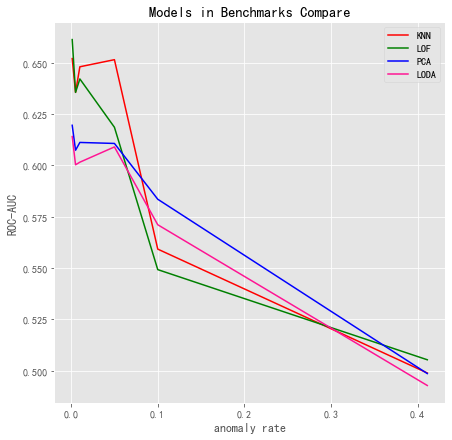

In [27]:
ar_mean.sort()
plt.figure(figsize=(7,7))
plt.xlabel('anomaly rate')
plt.ylabel('ROC-AUC')
colors = ['r', 'g', 'b', '#FF1493']
i = 0
for cls in classifiers:
    mean_y = [np.mean(results[cls][300:480]), np.mean(results[cls][480:670]), np.mean(results[cls][670:850]), 
              np.mean(results[cls][850:1030]), np.mean(results[cls][1030:1210]), np.mean(results[cls][:300]), ]    
    plt.plot(ar_mean, mean_y, color=colors[i], label=cls)
    i += 1
plt.title('Models in Benchmarks Compare')
plt.legend(loc="upper right")
plt.show()

### 由图可知，所有算法在高异常点比例下表现均较差，在低异常点比例下表现较好。其中，KNN和LOF在不同异常点下的差异最为明显，低异常点下表现最好，高异常点下基本表现较差。相反，PCA在不同异常点比例下表现较为鲁棒。
### 说明基于近邻的(KNN，LOF)的方法对异常点比例较为敏感，Linear Model(PCA)和Outlier Ensembles(LODA)方法较为鲁棒。